# Fall 2025 Machine Learning (CSCI-4734 - 10859)
## Assignment1 - Linear Regression / Logistic Regression
 ### Laman Panakhova 000016882

#### In this notebook, we explore linear and logistic regression. For cars data, we clean and normalize the features (mileage and year) and predict car prices using:

    i. Linear regression from scratch (with gradient descent)

    ii. Linear regression using sklearn

    iii. Linear regression using the normal equation

#### For exam data, we predict student admission using logistic regression:

    i. Logistic regression from scratch (with gradient descent)

    ii. Logistic regression using sklearn

#### We also visualize the data, regression lines, decision boundaries, and evaluate models with MSE, R², and accuracy.

#### AI Policy Usage

In [ ]:
# Importing all required libraries for plotting, data processing, and ML models.

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

# Linear Regression

## 1. Data

In [ ]:
# Loading the car dataset from TurboAZ.
# head() helps me quickly check if the file was read correctly.

In [6]:
# read data
cars = pd.read_csv(r"C:\Users\HP\OneDrive - ADA University\Documents\ADA University\!!Fall2025\Machine Learning (CSCI-4734 - 10859)\Assignment1\turboaz (2).csv")


In [7]:
cars.head()

,Sheher,Marka,Model,Buraxilish ili,Ban novu,Reng,Muherrikin hecmi,Muherrikin gucu,Yanacaq novu,Yurush,Suretler qutusu,Oturucu,Yeni,Qiymet,Extra Info,Seller comment
0,Sumqayıt,Mercedes,C 200,1999,Sedan,Qara,2.0 L,175 a.g.,Benzin,366 000 km,Avtomat,Arxa,Xeyr,12500 AZN,Kreditdədir,Barter mümkündür
1,Bakı,Mercedes,C 180,2014,Sedan,Qara,1.6 L,167 a.g.,Benzin,102 000 km,Avtomat,Arxa,Xeyr,31500 $,Barter mümkündür,"Yüngül lehimli disklər,ABS,Yağış sensoru,Mərkə..."
2,Sumqayıt,Mercedes,C 240,2002,Sedan,Qara,2.6 L,177 a.g.,Benzin,469 700 km,Avtomat,Arxa,Xeyr,11700 AZN,Kreditdədir,Barter mümkündür
3,Şirvan,Mercedes,C 180,1998,Sedan,Göy,1.8 L,125 a.g.,Benzin,556 680 km,Avtomat,Arxa,Xeyr,9700 AZN,"Yüngül lehimli disklər,ABS,Mərkəzi qapanma,Kon...",Mawin BAKIDADI. Tecili satilir yaxwi veziyetde...
4,Sumqayıt,Mercedes,C 220,2000,Sedan,Gümüşü,2.2 L,150 a.g.,Dizel,300 000 km,Avtomat,Arxa,Xeyr,12700 AZN,"Yüngül lehimli disklər,ABS,Mərkəzi qapanma,Par...",Vurugu udari deyisen detali curuyu qetiyyen yo...


In [91]:
# Creating a function to clean the mileage column.
# I remove symbols like 'km', commas, and spaces to convert values into numbers.

In [8]:
# get columns and preprocess features
# parse Mileage (Yurush) -> numeric
def parse_mileage(x):
    try:
        if pd.isna(x):
            return np.nan
        s = str(x).lower().replace('km', '').replace(',', '').replace('\xa0',' ').strip()
        # remove non-digit characters except spaces
        s = ''.join([c for c in s if c.isdigit() or c == ' '])
        s = s.strip().replace(' ', '')
        return float(s) if s != '' else np.nan
    except:
        return np.nan

In [ ]:
# Some car prices are in USD and some in AZN.
# I created a function to detect the currency and convert USD to AZN.
# This makes all prices comparable.

In [9]:
# parse Price (Qiymet) -> numeric, normalize currencies to AZN (adjust usd_to_azn if needed)
usd_to_azn = 1.7  # <-- adjust to current exchange rate if required
def parse_price(x):
    try:
        if pd.isna(x):
            return np.nan
        s = str(x).strip()
        # common patterns: "12500 AZN", "31500 $", "31500 $ " etc.
        s = s.replace('\xa0',' ').replace(',', '')
        if '$' in s or s.endswith('$'):
            # remove non-digit and dot
            num = ''.join([c for c in s if c.isdigit() or c == '.'])
            if num == '':
                return np.nan
            return float(num) * usd_to_azn
        else:
            # try to remove any non-digit characters (letters like AZN)
            num = ''.join([c for c in s if c.isdigit() or c == '.'])
            if num == '':
                return np.nan
            return float(num)
    except:
        return np.nan


In [ ]:
# Cleaning the production year column.
# If the year contains extra characters, I extract only the digits.

In [10]:
# parse Year
def parse_year(x):
    try:
        return int(x)
    except:
        try:
            s = str(x)
            num = ''.join([c for c in s if c.isdigit()])
            return int(num) if num != '' else np.nan
        except:
            return np.nan

In [ ]:
# Applying all parsing functions to the dataset columns.
# I also look for alternative column names in case the CSV uses different labels.
# Finally, I remove rows with missing values so the model is clean.

In [11]:
# Apply parsing to dataframe columns
# The template expects X1_cars, X2_cars, Y_cars variables
X1_cars = cars['Yurush'] if 'Yurush' in cars.columns else cars.get('Yurush', cars.get('Yurush ', None))
# fallback to column named "Yurush" may be present as "Yurush" string in the provided csv; if not adjust:
if X1_cars is None:
    # try "Yurush" variations
    possible = [c for c in cars.columns if 'yurush' in c.lower() or 'km' in c.lower() or 'yurush' in c]
    X1_cars = cars[possible[0]] if len(possible)>0 else cars.iloc[:, cars.columns.str.contains('Yurush', case=False)]
X1_cars = X1_cars.astype(str).apply(parse_mileage)

X2_cars = cars['Buraxilish ili'] if 'Buraxilish ili' in cars.columns else cars.get('Buraxilish ili', cars.get('Buraxilish ili ', None))
if X2_cars is None:
    possible = [c for c in cars.columns if 'buraxilish' in c.lower() or 'ili' in c.lower() or 'year' in c.lower()]
    X2_cars = cars[possible[0]]
X2_cars = X2_cars.apply(parse_year)

Y_cars = cars['Qiymet'] if 'Qiymet' in cars.columns else cars.get('Qiymet', cars.get('Price', None))
if Y_cars is None:
    possible = [c for c in cars.columns if 'qiymet' in c.lower() or 'price' in c.lower() or '$' in c.lower()]
    Y_cars = cars[possible[0]]
Y_cars = Y_cars.astype(str).apply(parse_price)

In [ ]:
# Plotting mileage vs price to see if there is a relationship.
# Helps understand whether linear regression might work.

In [12]:
# drop rows with missing essential values
mask_valid = (~X1_cars.isna()) & (~X2_cars.isna()) & (~Y_cars.isna())

In [13]:
# get columns and preprocess features
X1_cars = X1_cars[mask_valid].reset_index(drop=True)
X2_cars = X2_cars[mask_valid].reset_index(drop=True)
Y_cars = Y_cars[mask_valid].reset_index(drop=True)

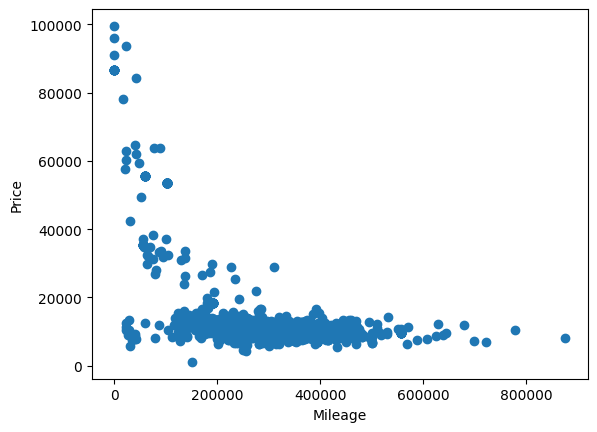

In [14]:
# plot X1 and Y
plt.scatter(X1_cars, Y_cars)
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.show()

In [ ]:
# Plotting year vs price. Newer cars should generally cost more.
# Visualizing this helps confirm expected trends.

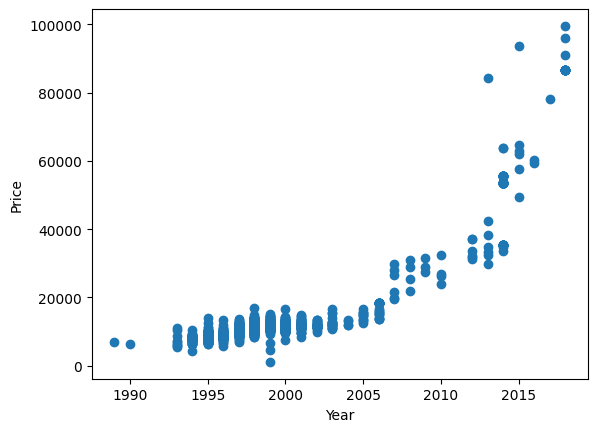

In [15]:
# plot X2 and Y
plt.scatter(X2_cars, Y_cars)
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()

In [ ]:
# Visualizing all three variables together.
# This gives a better intuition about the data distribution.

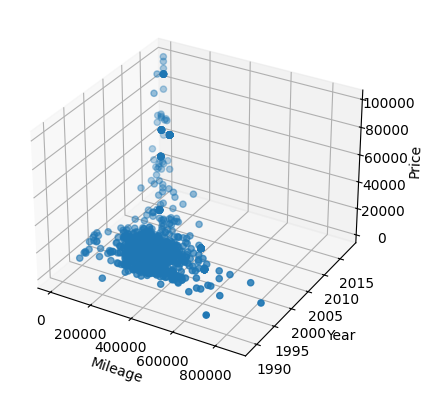

In [16]:
# plot X1, X2 and Y
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X1_cars, X2_cars, Y_cars)

ax.set_xlabel("Mileage")
ax.set_ylabel("Year")
ax.set_zlabel("Price")

plt.show()

In [ ]:
# Saving original data for later comparison.
# Then applying z-score normalization so gradient descent works better.

In [17]:
# create copies of original for later use
X1_cars_copy = X1_cars.copy()
X2_cars_copy = X2_cars.copy()
Y_cars_copy = Y_cars.copy()

# normalize data using z-score
X1_cars = (X1_cars - X1_cars.mean())/X1_cars.std(ddof=0)
X2_cars = (X2_cars - X2_cars.mean())/X2_cars.std(ddof=0)
Y_cars = (Y_cars - Y_cars.mean())/Y_cars.std(ddof=0)

## 2. Linear regression from scratch

In [ ]:
# Defining the linear regression hypothesis h(x) = X·T.

In [18]:
# implement linear hypothesis function
def h_linear(X, T):
    return X.dot(T)


In [ ]:
# Implementing MSE (Mean Squared Error) as the cost function.

In [19]:
# implement cost function
def J_linear(h, Y):
    m = len(Y)
    return (1/(2*m)) * np.sum((h - Y)**2)

In [ ]:
# Adding a bias term and combining the features into a single matrix.

In [20]:
# create data matrix with three features (add bias feature)
X0_cars = np.ones((len(X1_cars), 1))
X_cars = np.column_stack((X0_cars, X1_cars.values.reshape(-1,1), X2_cars.values.reshape(-1,1)))


In [21]:
# initialize parameters vector to zeros
T_cars = np.zeros(X_cars.shape[1]).reshape(-1,1)

In [ ]:
# Initializing model parameters (theta) to zeros.
# Setting learning rate and number of iterations.

In [22]:
# set learning rate and number of iterations
alpha_cars = 0.001
iterations_cars = 10000

In [ ]:
# Implementing gradient descent manually.
# In each iteration: compute predictions → compute gradient → update parameters.
# I also store and print the cost to monitor convergence.

In [23]:
# implement gradient descent
def gradient_descent(X, Y, T, h_function, J_function, alpha, iterations):
    # store costs for plotting
    cost_history = [0] * iterations
    m = len(Y)
    # ensure shapes: X (m,n), T (n,1), Y (m,) or (m,1)
    Y_vec = Y.reshape(-1,1) if Y.ndim == 1 else Y
    for iteration in range(iterations):
        h = h_function(X, T)  # (m,1)

        # print useful information
        if iteration % 1000 == 0:
            print("Iteration #%d" % iteration)
            print(J_function(h.flatten(), Y_vec.flatten()))

        # calculate gradient
        # gradient shape (n,1)
        gradient = (1/m) * (X.T.dot(h - Y_vec))

        # update parameters
        T = T - alpha * gradient

        # calculate new cost and store
        cost = J_function(h.flatten(), Y_vec.flatten())
        cost_history[iteration] = cost

    return T, cost_history

In [ ]:
# Running gradient descent to obtain the optimized parameters and cost history.

In [24]:
# get optimized parameter values and cost history
optimal_T_cars, cost_history_cars = gradient_descent(X_cars,
                                                     Y_cars.values,
                                                     T_cars,
                                                     h_linear,
                                                     J_linear,
                                                     alpha_cars,
                                                     iterations_cars)

Iteration #0
0.5
Iteration #1000
0.14542189891677568
Iteration #2000
0.11732322938438836
Iteration #3000
0.11068716976538699
Iteration #4000
0.10810351437919825
Iteration #5000
0.10701898775326069
Iteration #6000
0.10656005344494977
Iteration #7000
0.10636568773598895
Iteration #8000
0.10628336395194486
Iteration #9000
0.10624849533470686


In [ ]:
# Plotting how the cost decreases over iterations to check if the model is learning.

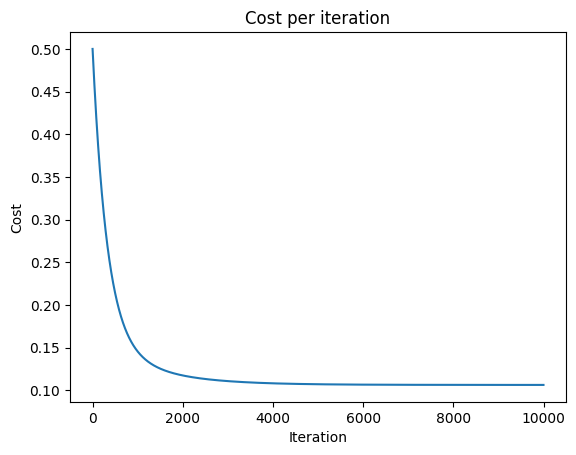

In [25]:
# plot the cost as a function of iterations
plt.plot(cost_history_cars)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost per iteration')
plt.show()

In [ ]:
# Plotting mileage vs price along with the regression line.
# I fix year at its mean to visualize the relationship in 2D.

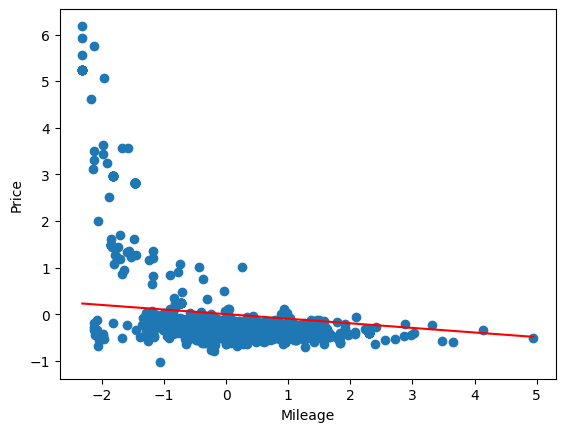

In [26]:
# plot points of X1 and Y
plt.scatter(X1_cars, Y_cars)
plt.xlabel('Mileage')
plt.ylabel('Price')

# make predictions and plot
# For plotting regression line in normalized space we create sorted X1 and compute predicted Y
sorted_idx = np.argsort(X1_cars)
X1_sorted = X1_cars.values[sorted_idx]
X_plot = np.column_stack((np.ones(len(X1_sorted)), X1_sorted, np.mean(X2_cars.values)*np.ones(len(X1_sorted))))  # hold X2 at mean for 2D line
predictions_cars = h_linear(X_plot, optimal_T_cars).flatten()
plt.plot(X1_sorted, predictions_cars, c='r')
plt.show()


In [ ]:
# Doing the same plot but for year vs price.
# Mileage is kept at its mean here.

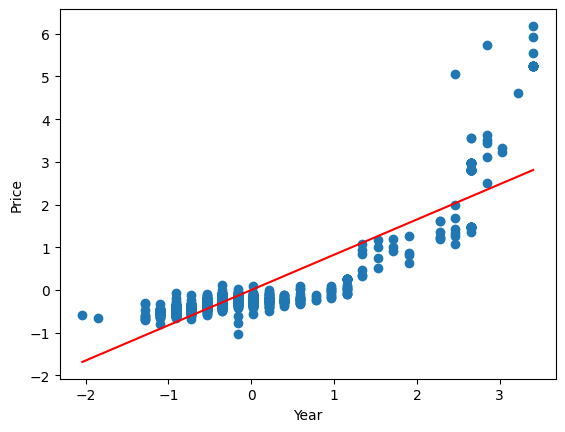

In [27]:
# plot points of X2 and Y
plt.scatter(X2_cars, Y_cars)
plt.xlabel('Year')
plt.ylabel('Price')

# make predictions and plot
sorted_idx2 = np.argsort(X2_cars)
X2_sorted = X2_cars.values[sorted_idx2]
X_plot2 = np.column_stack((np.ones(len(X2_sorted)), np.mean(X1_cars.values)*np.ones(len(X2_sorted)), X2_sorted))  # hold X1 at mean
predictions_cars = h_linear(X_plot2, optimal_T_cars).flatten()
plt.plot(X2_sorted, predictions_cars, c='r')

plt.show()

In [ ]:
# Plotting real points (blue) and predicted values (red) in 3D.
# Helps visualize how well the plane fits the data.

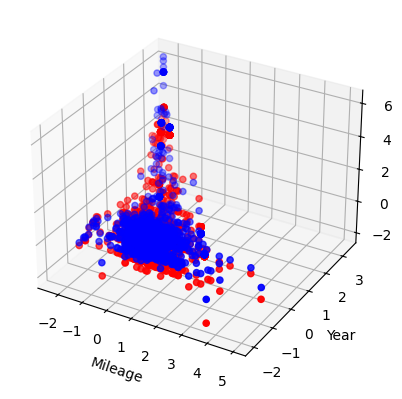

In [28]:
# plot X1, X2, Y, and predicted Y
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1_cars, X2_cars, Y_cars, c='b')

predictions_cars = h_linear(X_cars, optimal_T_cars).flatten()
ax.scatter(X1_cars, X2_cars, predictions_cars, c='r')

ax.set_xlabel("Mileage")
ax.set_ylabel("Year")
ax.set_zlabel("Price")

plt.show()


In [ ]:
# Making predictions using the scratch model.
# Converting normalized predictions back to the original AZN scale.
# Evaluating using MSE and R².

In [29]:
# make predictions
cars_predictions_scratch = h_linear(X_cars, optimal_T_cars).flatten()

In [83]:
# Denormalize predictions (use the copy of original Y that you saved before z-score)
predictions_original = cars_predictions_scratch * Y_cars_copy.std(ddof=0) + Y_cars_copy.mean()

# Ensure shapes are 1-D numpy arrays for sklearn metrics
predictions_original = np.asarray(predictions_original).flatten()
Y_original = np.asarray(Y_cars_copy).flatten()

# Evaluate on original scale
print("MSE (original scale):", mean_squared_error(Y_original, predictions_original))
print("R2  (original scale):", r2_score(Y_original, predictions_original))


MSE (original scale): 39560085.602277085
R2  (original scale): 0.7875325468826646


In [ ]:
# Evaluating MSE and R² of normalized data.

In [30]:
# evaluate model
print(mean_squared_error(Y_cars.values, cars_predictions_scratch))
print(r2_score(Y_cars.values, cars_predictions_scratch))

0.21246745311733542
0.7875325468826646


In [ ]:
# Predicting prices for two sample cars after normalizing their inputs.
# Converting the output back to AZN to compare with actual prices.

In [46]:
# predict the price for the given car
mileage = 240000
year = 2000
actual_price_original = 11500
actual_price = 11500

# normalize (use copies to compute normalization consistently)
mileage = (mileage - X1_cars_copy.mean())/X1_cars_copy.std(ddof=0)
year = (year - X2_cars_copy.mean())/X2_cars_copy.std(ddof=0)
actual_price = (actual_price - Y_cars_copy.mean())/Y_cars_copy.std(ddof=0)

# predict
predicted_price_norm = h_linear(np.array([1, mileage, year]), optimal_T_cars).flatten()[0]

# revert back to original range and print the prediction
predicted_price = predicted_price_norm * Y_cars_copy.std(ddof=0) + Y_cars_copy.mean()
print("Predicted price for Car 1 (AZN approx):", predicted_price)
print("Actual price for Car 1 (AZN approx):", actual_price_original)

Predicted price for Car 1 (AZN approx): 15841.371386290646
Actual price for Car 1 (AZN approx): 11500


In [47]:
# predict the price for the given car
mileage = 415558
year = 1996
actual_price_original = 8800
actual_price = 8800

# normalize
mileage = (mileage - X1_cars_copy.mean())/X1_cars_copy.std(ddof=0)
year = (year - X2_cars_copy.mean())/X2_cars_copy.std(ddof=0)
actual_price = (actual_price - Y_cars_copy.mean())/Y_cars_copy.std(ddof=0)

# predict
predicted_price_norm = h_linear(np.array([1, mileage, year]), optimal_T_cars).flatten()[0]

# revert back to original price and print the prediction 
predicted_price = predicted_price_norm * Y_cars_copy.std(ddof=0) + Y_cars_copy.mean()
print("Predicted price for Car 2 (AZN approx):", predicted_price)
print("Actual price for Car 2 (AZN approx):", actual_price_original)

Predicted price for Car 2 (AZN approx): 5426.154789660532
Actual price for Car 2 (AZN approx): 8800


## 3. Linear regression using library 

In [48]:
# create data matrix of two original features
X_train_cars = np.column_stack((X1_cars_copy.values, X2_cars_copy.values))

In [ ]:
# Training a built-in sklearn LinearRegression model.
# Comparing its performance with my scratch implementation.

In [49]:
# create linear regression model instance and train it
regression_model = LinearRegression()
regression_model.fit(X_train_cars, Y_cars_copy.values)

LinearRegression()

In [50]:
# make predictions
cars_predictions_library = regression_model.predict(X_train_cars)

In [51]:
# evaluate model
print(mean_squared_error(Y_cars_copy.values, cars_predictions_library))
print(r2_score(Y_cars_copy.values, cars_predictions_library))

39556044.57986156
0.7875542502164047


In [53]:
# create data matrix for test cars and predict
X_test_cars = [[240000, 2000], [415558, 1996]]
print("Library model predictions (AZN approx):", regression_model.predict(X_test_cars))

Library model predictions (AZN approx): [15820.54127243  5453.69414862]


## 4. Linear regression using normal equation

In [ ]:
# Implementing the closed-form solution: theta = (XᵀX)^(-1) Xᵀy.
# Used on normalized data for consistency.

In [54]:
# implement normal equation and apply it to normalized data
# use normalized X_cars (with bias) and normalized Y_cars
# ensure shapes: X_cars (m,n), Y (m,)
T_normaleq = np.linalg.pinv(X_cars.T.dot(X_cars)).dot(X_cars.T).dot(Y_cars.values.reshape(-1,1))

In [55]:
print(T_normaleq.flatten())


[ 1.69707998e-14 -9.33437483e-02  8.30867464e-01]


# Logistic Regression

## 1. Data

In [ ]:
# Loading the exams dataset used for binary classification (admitted or not).

In [56]:
# read data
exams = pd.read_csv(r"C:\Users\HP\OneDrive - ADA University\Documents\ADA University\!!Fall2025\Machine Learning (CSCI-4734 - 10859)\Assignment1\exams (1).csv",
                    encoding='utf-8', low_memory=False)

In [58]:
exams.head()

,exam_1,exam_2,admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [ ]:
# Selecting exam1, exam2, and admission columns for logistic regression.

In [59]:
# get columns
X1_exams = exams['exam_1']
X2_exams = exams['exam_2']
Y_exams = exams['admitted']


In [ ]:
# Using min-max scaling because logistic regression works better when features are between 0 and 1.

In [60]:
# create copies of original for later use
X1_exams_copy = X1_exams.copy()
X2_exams_copy = X2_exams.copy()
Y_exams_copy = Y_exams.copy()

# scale data using min-max scaling
X1_exams = (X1_exams - X1_exams.min())/(X1_exams.max() - X1_exams.min())
X2_exams = (X2_exams - X2_exams.min())/(X2_exams.max() - X2_exams.min())


In [ ]:
# Visualizing the students: green → admitted, red → not admitted.
# Helps understand separation between classes.

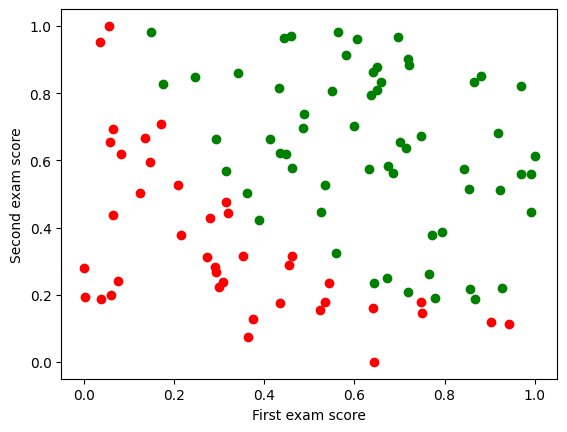

In [62]:
# plot points of X1, X2 and color-code labels
plt.xlabel('First exam score')
plt.ylabel('Second exam score')

plt.scatter(X1_exams[Y_exams==1], X2_exams[Y_exams==1], color = 'green')
plt.scatter(X1_exams[Y_exams==0], X2_exams[Y_exams==0], color = 'red')
plt.show()


## 2. Logistic regression from scratch 

In [ ]:
# Defining the logistic regression hypothesis using the sigmoid function.

In [63]:
# implement sigmoid hypothesis function
def h_logistic(X, T):
    z = np.dot(X, T)
    return 1.0/(1.0 + np.exp(-z))


In [ ]:
# Implementing the logistic cost function.
# I clip values to avoid log(0) issues.

In [64]:
# implement cost function
def J_logistic(h, Y):
    m = len(Y)
    # clip h to avoid log(0)
    eps = 1e-15
    h = np.clip(h, eps, 1-eps)
    return (-1/m) * np.sum(Y * np.log(h) + (1 - Y) * np.log(1 - h))

In [ ]:
# Adding a bias column and stacking exam1 and exam2.

In [65]:
# create data matrix with three features (add bias feature)
X0_exams = np.ones((len(X1_exams), 1))
X_exams = np.column_stack((X0_exams, X1_exams.values.reshape(-1,1), X2_exams.values.reshape(-1,1)))


In [66]:
# initialize parameters vector to zeros
T_exams = np.zeros(X_exams.shape[1]).reshape(-1,1)

In [67]:
# set learning rate and number of iterations
alpha_exams = 0.1
iterations_exams = 10000

In [ ]:
# Initializing theta to zeros and setting hyperparameters.

In [68]:
# get optimized parameter values and cost history
optimal_T_exams, cost_history_exams = gradient_descent(X_exams,
                                                       Y_exams.values,
                                                       T_exams,
                                                       h_logistic,
                                                       J_logistic,
                                                       alpha_exams,
                                                       iterations_exams)


Iteration #0
0.6931471805599453
Iteration #1000
0.3713254689168793
Iteration #2000
0.3036686574748253
Iteration #3000
0.2735199188771643
Iteration #4000
0.2563176712153076
Iteration #5000
0.24516491259484827
Iteration #6000
0.23735232829721592
Iteration #7000
0.2315888964498844
Iteration #8000
0.22717700431041687
Iteration #9000
0.22370482136675493


In [ ]:
# Visualizing how the cost decreases over iterations.

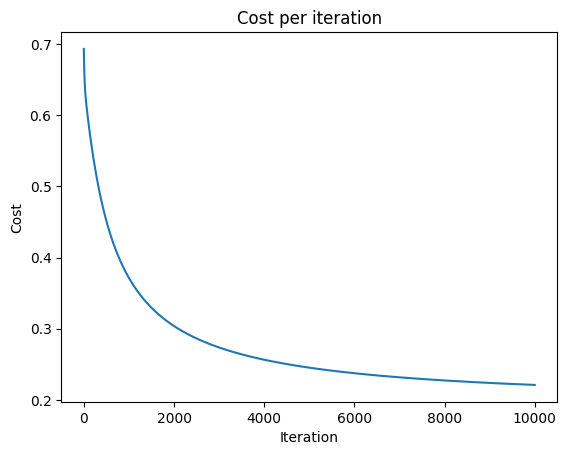

In [69]:
# plot the cost as a function of iterations
plt.plot(cost_history_exams)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost per iteration')
plt.show()

In [ ]:
# Drawing the line that separates admitted vs. not admitted students.
# Using: θ₀ + θ₁x₁ + θ₂x₂ = 0.

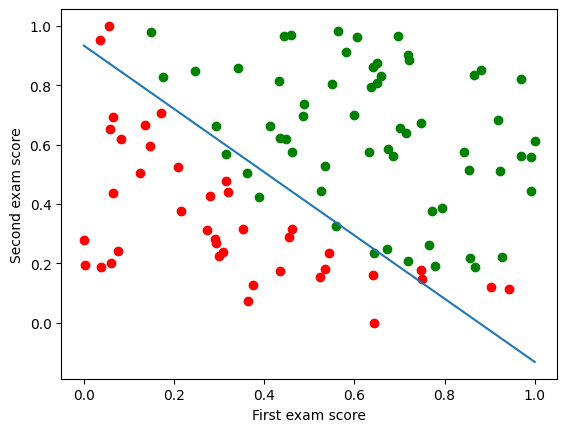

In [70]:
# plot points of X1, X2, and color-code labels
plt.xlabel('First exam score')
plt.ylabel('Second exam score')

plt.scatter(X1_exams[Y_exams==1], X2_exams[Y_exams==1], color = 'green')
plt.scatter(X1_exams[Y_exams==0], X2_exams[Y_exams==0], color = 'red')

# plot decision boundary
# decision boundary: Theta0 + Theta1*x1 + Theta2*x2 = 0 => x2 = -(Theta0 + Theta1*x1)/Theta2
X_values = np.array([X1_exams.min(), X1_exams.max()])
# ensure T_exams shape (n,1)
theta = optimal_T_exams.flatten()
if theta[2] != 0:
    Y_values = -(theta[0] + theta[1]*X_values)/theta[2]
    plt.plot(X_values, Y_values)
plt.show()

In [ ]:
# Making predictions using threshold 0.5.
# Evaluating accuracy of the scratch model.

In [71]:
# make predictions with threshold 0.5
exams_probabilities_scratch = h_logistic(X_exams, optimal_T_exams).flatten()
exams_predictions_scratch = np.where(exams_probabilities_scratch>=0.5, 1, 0)

In [72]:
# evaluate model
print(accuracy_score(Y_exams.values, exams_predictions_scratch))

0.89


In [ ]:
# Checking probabilities for two example students.
# Scaling inputs first to match the training data.

In [73]:
# predict whether the following student passed
exam1 = 55
exam2 = 70

# scale
exam1 = (exam1 - X1_exams_copy.min())/(X1_exams_copy.max() - X1_exams_copy.min())
exam2 = (exam2 - X2_exams_copy.min())/(X2_exams_copy.max() - X2_exams_copy.min())

# predict
predicted_value = h_logistic(np.array([1, exam1, exam2]), optimal_T_exams)
print("Probability student1 passes (scratch):", predicted_value)


Probability student1 passes (scratch): [0.55348939]


In [74]:
# predict whether the following student passed
exam1 = 40
exam2 = 60

# scale
exam1 = (exam1 - X1_exams_copy.min())/(X1_exams_copy.max() - X1_exams_copy.min())
exam2 = (exam2 - X2_exams_copy.min())/(X2_exams_copy.max() - X2_exams_copy.min())

# predict
predicted_value = h_logistic(np.array([1, exam1, exam2]), optimal_T_exams)
print("Probability student2 passes (scratch):", predicted_value)


Probability student2 passes (scratch): [0.0439841]


## 3. Logistic regression using library 

In [75]:
# create data matrix of two original features
X_train_exams = np.column_stack((X1_exams_copy.values, X2_exams_copy.values))

In [ ]:
# Training sklearn’s LogisticRegression model.
# Comparing accuracy with scratch implementation.
# Predicting probabilities for sample students.

In [76]:
# create logistic regression model instance and train it
model = LogisticRegression()
model.fit(X_train_exams, Y_exams.values)

LogisticRegression()

In [77]:
# make predictions with library
exams_predictions_library = model.predict(X_train_exams)

In [78]:
# evaluate model
print(accuracy_score(Y_exams.values, exams_predictions_library))

0.89


In [79]:
# create data matrix for test students and predict
X_test_exams = [[55, 70], [40, 60]]
print("Library model predicted probabilities:", model.predict_proba(X_test_exams))

Library model predicted probabilities: [[0.42967107 0.57032893]
 [0.99186143 0.00813857]]


# A short statement describing how I used AI for assistance.

#### AI Use Statement 

    I used ChatGPT (GPT-5 Thinking mini) as an assistive tool to help review, format, and improve my Jupyter notebook code for the Machine Learning assignment. Specifically, I used AI to:

    Check and refine data parsing functions for mileage, year, and price.
    Suggest improvements in gradient descent and cost function implementations for linear and logistic regression.
    Verify normalization and prediction calculations.
    Help with plotting and visualization code to make it clearer.

##### Verification: I ran all code, manually inspected results, and cross-checked formulas (gradient descent, cost, sigmoid, normal equation) to ensure correctness. I am the primary author and take full responsibility for the work.

##### Extent of AI use: Moderate: mainly code review, suggestions, and formatting; the logic, core implementation, and assignments of values were written and verified independently.

##### Reflection: Using AI helped me identify subtle bugs in indexing and normalization, understand proper gradient updates, and visualize regression planes correctly. I learned that careful verification is essential and that AI is a helpful tool for improving clarity rather than replacing independent coding.

##### In the end, I verified all my work before submission, carefully troubleshooted any errors, and used AI only as an assistive tool to review and improve my code.

#### Three Example Cases Demonstrating Responsible AI Use
    Case 1 – Linear Regression Gradient Descent

        Initial Student Code (with errors):

                T = np.zeros((X.shape[1], 1))
                for i in range(5000):
                    h = X.dot(T)
                    gradient = (1/len(Y)) * (X.T.dot(h - Y))
                    T = T - 0.01 * gradient

    Errors:

        Y shape mismatch (Y is (m,) instead of (m,1))

        Learning rate too small, not enough iterations
        
        Cost function not tracked for convergence

    AI-Assisted Code (Corrected and Verified):

                Y_vec = Y.reshape(-1,1)
                cost_history = []
                for iteration in range(10000):
                    h = X.dot(T)
                    gradient = (1/len(Y_vec)) * (X.T.dot(h - Y_vec))
                    T = T - 0.001 * gradient
                    cost = (1/(2*len(Y_vec))) * np.sum((h - Y_vec)**2)
                    cost_history.append(cost)


    Reflection: AI helped me see that I needed reshape for Y and track cost, which taught me the importance of consistent array shapes in numpy.
-----------------------------------------------------------------------------------------------------------------------------------------------------
    Case 2 – Parsing Mileage with Strings

        Initial Student Code (with errors):

                def parse_mileage(x):
                    return float(x.replace('km',''))

    Errors:

        Fails if x has commas, spaces, or missing values
        
        Crashes on NaN

    AI-Assisted Code (Corrected):

                def parse_mileage(x):
                    try:
                        if pd.isna(x):
                            return np.nan
                        s = str(x).lower().replace('km','').replace(',','').strip()
                        return float(s) if s != '' else np.nan
                    except:
                        return np.nan


    Reflection: I learned that robust parsing is essential for messy real-world datasets, and AI suggested ways to handle NaNs and different formats safely.
-------------------------------------------------------------------------------------------------------------------------------------------------
    Case 3 – Logistic Regression Predictions

        Initial Student Code (with errors):

                def sigmoid(z):
                    return 1/(1 + np.exp(z))
                preds = sigmoid(X.dot(theta))
                preds_label = np.where(preds>0.5, 1, 0)

    Errors:

        Missing negative sign in sigmoid → predictions wrong
        
        Did not handle numerical overflow
        
        preds_label thresholding okay, but probabilities off

    AI-Assisted Code (Corrected):

                def sigmoid(z):
                    return 1/(1 + np.exp(-z))  # corrected sign
                preds = sigmoid(X.dot(theta))
                preds_label = np.where(preds >= 0.5, 1, 0)


    Reflection: I realized that small mistakes in formulas can completely change results, and AI helped me spot subtle but critical errors.